In [1]:
from platform import python_version
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import time
import csv
python_version()

'2.7.16'

In [2]:
from blimpy import Waterfall
fb = Waterfall('ics_a.fil', max_load=10)
fb_voy = Waterfall('voyager.fil')

No handlers could be found for logger "hdf5plugin"


blimpy.io.base_reader WARNING  Setting data limit != 1GB, please handle with care!


extracting integration 0...


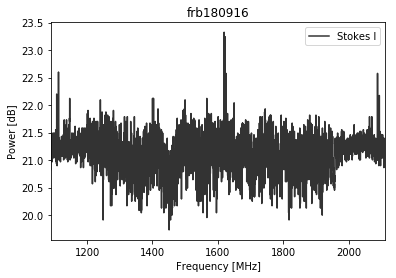

In [3]:
data = fb.data
fb.plot_spectrum(logged=True)

In [4]:
fb.info()


--- File Info ---
    telescope_id :                                0
     rawdatafile :                                 
     source_name :                        frb180916
   tstart (ISOT) :          2020-10-22T17:04:56.000
    tstart (MJD) :                    59144.7117593
       data_type :                                1
          nchans :                             4096
           ibeam :                                0
           tsamp :                          0.00048
            foff :                            -0.25
         src_raj :                     1:57:59.4521
         src_dej :                    65:44:03.8249
          nbeams :                                1
        az_start :                              0.0
            fch1 :                         2112.125
        za_start :                              0.0
      machine_id :                                0
            nifs :                                1
           nbits :                           

In [5]:
fb_voy.info()


--- File Info ---
    telescope_id :                                6
     rawdatafile : guppi_57650_67573_Voyager1_0002.0000.raw
     source_name :                         Voyager1
       data_type :                                1
          nchans :                          1048576
           ibeam :                                1
            nifs :                                1
           tsamp :                     18.253611008
            foff :          -2.7939677238464355e-06
         src_raj :                     17:10:03.984
         src_dej :                       12:10:58.8
   tstart (ISOT) :          2016-09-19T18:46:13.000
    tstart (MJD) :                    57650.7820949
        az_start :                              0.0
            fch1 :                8421.386717353016
          nbeams :                                1
      machine_id :                               20
        za_start :                              0.0
           nbits :                   

In [6]:
def mad(x):
    med = np.median(x);
    return np.median([abs(n-med) for n in x])

In [7]:
from astropy import stats
m = mad([1,2,3])
m

1.0

In [25]:
plt.rcParams['axes.formatter.useoffset'] = False


MAX_PLT_POINTS      = 65536                  # Max number of points in matplotlib plot
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot
def rebin(d, n_x=None, n_y=None, n_z=None):
    """ Rebin data by averaging bins together
    Args:
    d (np.array): data
    n_x (int): number of bins in x dir to rebin into one
    n_y (int): number of bins in y dir to rebin into one
    Returns:
    d: rebinned data with shape (n_x, n_y)
    """
    n_x = 1 if n_x is None else n_x
    n_y = 1 if n_y is None else n_y
    n_z = 1 if n_z is None else n_z

    if d.ndim == 3:
        d = d[:int(d.shape[0] // n_x) * n_x, :int(d.shape[1] // n_y) * n_y, :int(d.shape[2] // n_z) * n_z]
        d = d.reshape((d.shape[0] // n_x, n_x, d.shape[1] // n_y, n_y, d.shape[2] // n_z, n_z))
        d = d.mean(axis=5)
        d = d.mean(axis=3)
        d = d.mean(axis=1)
    elif d.ndim == 2:
        d = d[:int(d.shape[0] // n_x) * n_x, :int(d.shape[1] // n_y) * n_y]
        d = d.reshape((d.shape[0] // n_x, n_x, d.shape[1] // n_y, n_y))
        d = d.mean(axis=3)
        d = d.mean(axis=1)
    elif d.ndim == 1:
        d = d[:int(d.shape[0] // n_x) * n_x]
        d = d.reshape((d.shape[0] // n_x, n_x))
        d = d.mean(axis=1)
    else:
        raise RuntimeError("Only NDIM <= 3 supported")
    return d

def db(x, offset=0):
    """ Convert linear to dB """
    return 10 * np.log10(x + offset)
def calc_extent(self, plot_f=None, plot_t=None, MJD_time=False):
    """ Setup plotting edges.
    """

    plot_f_begin = plot_f[0]
    plot_f_end = plot_f[-1] + (plot_f[1] - plot_f[0])

    plot_t_begin = self.timestamps[0]
    plot_t_end = self.timestamps[-1] + (self.timestamps[1] - self.timestamps[0])

    if MJD_time:
        extent = (plot_f_begin, plot_f_end, plot_t_begin, plot_t_end)
    else:
        extent = (plot_f_begin, plot_f_end, 0.0, (plot_t_end - plot_t_begin) * 24. * 60. * 60)

    return extent
def plot_wf(wf, f_start=None, f_stop=None, if_id=0, logged=True, cb=True, MJD_time=False, **kwargs):
    """ Plot waterfall of data
    Args:
        f_start (float): start frequency, in MHz
        f_stop (float): stop frequency, in MHz
        logged (bool): Plot in linear (False) or dB units (True),
        cb (bool): for plotting the colorbar
        kwargs: keyword args to be passed to matplotlib imshow()
    """

    plot_f, plot_data = wf.grab_data(f_start, f_stop, if_id)

    # Using accending frequency for all plots.
    if wf.header['foff'] < 0:
        plot_data = plot_data[..., ::-1]  # Reverse data
        plot_f = plot_f[::-1]

    if logged:
        plot_data = db(plot_data)

    # Make sure waterfall plot is under 4k*4k
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = int(plot_data.shape[0] / MAX_IMSHOW_POINTS[0])

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y = int(plot_data.shape[1] / MAX_IMSHOW_POINTS[1])

    plot_data = rebin(plot_data, dec_fac_x, dec_fac_y)

    try:
        plt.title(wf.header['source_name'])
    except KeyError:
        plt.title(wf.filename)

    extent = calc_extent(wf, plot_f=plot_f, plot_t=wf.timestamps, MJD_time=MJD_time)

    plt.imshow(plot_data.astype(np.float32),
               aspect='auto',
               origin='lower',
               rasterized=True,
               interpolation='nearest',
               extent=extent,
               cmap='viridis',
               **kwargs
               )
    if cb:
        plt.colorbar()
    plt.xlabel("Frequency [MHz]")
    if MJD_time:
        plt.ylabel("Time [MJD]")
    else:
        plt.ylabel("Time [s]")

In [12]:
plotf, plotdata = fb.grab_data(f_start=1600,f_stop=1621)
plotdata

array([[124, 133, 124, ..., 129, 140, 120],
       [125, 130, 124, ..., 132, 126, 140],
       [127, 131, 124, ..., 119, 135, 134],
       ...,
       [122, 122, 125, ..., 139, 143, 132],
       [121, 122, 123, ..., 129, 143, 147],
       [120, 122, 123, ..., 131, 125, 110]], dtype=uint8)

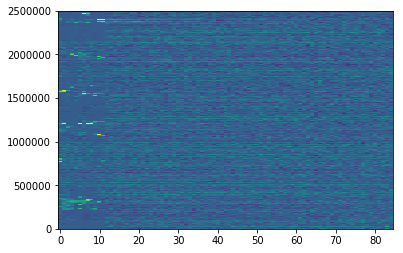

In [24]:
plt.imshow(plotdata,
               aspect='auto',
               origin='lower',
               rasterized=True,
               interpolation='nearest',
               cmap='viridis',
               )

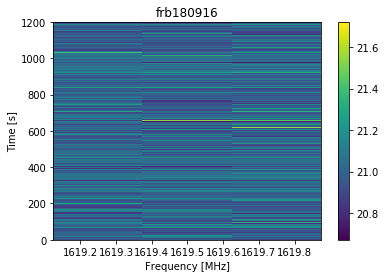

In [27]:
plot_wf(fb, f_start=1619, f_stop=1619.5)

In [45]:
#mad(plotdata)
def mad_scale(x, mad):
    median = np.median(x)
l=[1,2,3]
k = 10**(0.5/10)
noise = np.random.normal(np.mean(l),np.sqrt(k),3) 
#mad = 0.67449sd
n = l+noise
print(np.std(l))
print(np.std(n))
(mad(n)-mad(l))/0.67449

0.816496580927726
1.136110698973664


0.48875538662226214

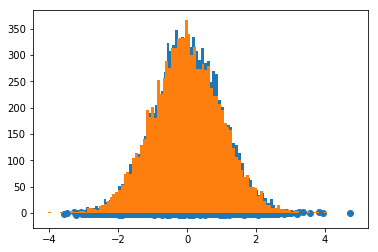

In [49]:
import numpy as np
import matplotlib.pyplot as plt
def f1(u1,u2):
    return np.sin(2*np.pi*u1)*np.sqrt(-2*np.log(u2))
def f2(u1,u2):
    return np.cos(2*np.pi*u1)*np.sqrt(-2*np.log(u2))
z1 = []
z2 = []
for i in range(10000):
    a = np.random.rand()
    b = np.random.rand()
    z1.append(f1(a,b))
    z2.append(f2(a,b))
plt.hist(z1,bins=100)
plt.hist(z2,bins=100)
plt.scatter(z1,z2)
plt.show()
yes, they follow gaussian distribution

In [2]:
import numpy as np
import matplotlib.pyplot as M
import os, sys
import glob
import time
import csv

from collections import namedtuple
from parse_cfg import parse_cfg as pcfg
from gen_furby import *

P = pcfg("params.cfg")
tsamp = P.tsamp         #seconds
nch = P.nch
database_directory = ""
order = "TF"

consts = {
    'tfactor': int( P.tsamp / (0.00001024*4) ),               #40.96 microseconds
    'ffactor': int( ((P.ftop-P.fbottom)/P.nch)/0.1),      #We dont want dmsmear to be approximated beyond 5 kHz chw. So ffactor = chw/ 0.005
    }

tmp = namedtuple("co", consts.keys())
C = tmp(*consts.values())

In [3]:
def disperse(frb, dm, pre_shift, dmsmear):
    tsum = 0
    if not dmsmear:
        ffactor = 1
    else:
        ffactor = C.ffactor

    nch = frb.shape[0] * ffactor
    tres = P.tsamp / C.tfactor *1e3  #ms. Effectively 10.24 micro-seconds, just framing it in terms of tres of Hires filterbanks

    chw = (P.ftop-P.fbottom)/nch
    f_ch = N.linspace(P.ftop - chw/2, P.fbottom + chw/2, nch)
    delays = P.D * f_ch**(-2) * dm    #Only works if freq in MHz and D in ms. Output delays in ms
    delays -= delays[int(nch/2)]
    delays_in_samples = N.rint(delays / tres).astype('int') #here we will have slight approximations due to quantization, but at 10.24 usec resolution they should be minimal

    nsamps = 9000 * C.tfactor
    start = nsamps/2 - int(pre_shift*C.tfactor)
    end = start + frb.shape[1]

    dispersed_frb = N.zeros(nch * nsamps).reshape(nch, nsamps)
    undispersed_time_series = N.zeros(nsamps)
    idxs = N.arange(nsamps)
    for i in range(nch):
        delay = delays_in_samples[i]
        mid_channel_coarse = int(i/ffactor) *ffactor + int(ffactor/2.0)
        dispersed_frb[i, start+delay: end+delay] += frb[int(i/ffactor)]
        undispersed_time_series += N.take(dispersed_frb[i], idxs + delays_in_samples[mid_channel_coarse], mode='wrap')
        tsum = undispersed_time_series.sum()
    final_dispersed_frb = fscrunch(dispersed_frb, ffactor)
    return final_dispersed_frb, undispersed_time_series/ffactor, nsamps/C.tfactor

In [4]:
def generate_frb(snr, width, kind, dm, scattered, smear):

    ID_series = P.ID_series
    while(True):
        ID = np.random.randint(( ID_series*P.N_per_IDseries + 1), (ID_series+1)*P.N_per_IDseries, 1)[0] 
        ID = str(ID).zfill(int(N.log10(P.N_per_IDseries)))
        name = "furby_"+ID
        if os.path.exists(database_directory+name):
            continue
        else:
            break

    if scattered:
        tau0 = np.abs(np.random.normal(loc = dm / 1000., scale = 2, size=1))[0] 
    else:
        tau0 = 0

    nsamps_for_gaussian = 5 * width            # = half of nsamps required for the gaussian. i.e. The total nsamps will be 10 * sigma.
    if nsamps_for_gaussian < 1:
        nsamps_for_gaussian = 1
    nsamps_for_exponential = int(6 * tau0 * ((P.ftop+P.fbottom)/2 / P.fbottom)**P.scattering_index)

    #Getting pure FRB
    frb = get_pure_frb(snr=snr, width = width, nch=nch, nsamps=nsamps_for_gaussian)
    pure_signal = N.sum(frb.flatten())
    
    #Creating frequency structure
    frb,f = create_freq_structure(frb, kind=kind)
    pure_width = pure_signal / np.max( frb.sum(axis=0) )   /C.tfactor
    pure_snr = pure_signal / (np.sqrt(nch) * get_clean_noise_rms() * N.sqrt(pure_width))
    
    #scattering
    if nsamps_for_exponential==0:
        print "Tau0 = 0, no scattering applied"
        pass
    else:
        frb = scatter(frb, tau0, nsamps_for_exponential, pure_snr)
    
    sky_signal = N.sum(frb.flatten())
    sky_frb_tseries = N.sum(frb, axis=0)
    sky_frb_top_hat_width = sky_signal / N.max(sky_frb_tseries) / C.tfactor
    sky_snr = sky_signal / ( get_clean_noise_rms() * N.sqrt(nch) * N.sqrt(sky_frb_top_hat_width) )
    
    frb_b_d = frb.copy()      #FRB before dispersing
    
    frb, undispersed_tseries, NSAMPS = disperse(frb, dm, pre_shift = nsamps_for_gaussian,dmsmear = smear) #Remember, nsamps_for_gaussian is already half the number of samples
    signal_after_disp = N.sum(frb.flatten())
    FWHM,maxima = get_FWHM(undispersed_tseries)
    
    #scrunch
    scrunched_frb = tscrunch(frb, C.tfactor)
    signal_after_scrunching = N.sum(scrunched_frb.flatten())
    
    final_top_hat_width = signal_after_scrunching / N.max(undispersed_tseries) / C.tfactor
    output_snr = signal_after_scrunching / (get_clean_noise_rms() * N.sqrt(nch) *  N.sqrt(final_top_hat_width) )
    
    final_frb = scrunched_frb.astype('float32')
    
    return final_frb

In [5]:
def generate_random_params(times):
    frbs = []
    frbs_params = []
    for i in range(times):
        frb_params = {}
        snr = np.random.uniform(2,20)
        w = np.random.uniform(0.5,5)
        width = w *1e-3/ P.tsamp
        dm = np.random.uniform(0,500)
        kind = np.random.choice(["flat", "slope", "smooth_envelope", "two_peaks", "three_peaks", "ASKAP"])
        scattered = np.random.choice([True, False])
        smear = np.random.choice([True, False])
        frb_params["id"] = i
        frb_params["snr"] = snr
        frb_params["width"] = width
        frb_params["kind"] = kind
        frb_params["dm"] = dm
        frb_params["scattered"] = scattered
        frb_params["smear"] = smear
        frbs_params.append(frb_params) # meta data
        frbs.append(generate_frb(snr,width, kind, dm, scattered, smear)) # frb data
    return frbs, frbs_params

In [6]:
frb_data, frb_metadata = generate_random_params(50)

Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied
Tau0 = 0, no scattering applied


In [9]:
os.remove("mock_frbs.csv")
with open('mock_frbs.csv', mode='w') as csv_file:
    fieldnames = ['id','dm', 'kind', 'scattered', 'smear', 'snr', 'width']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for data in frb_metadata:
        writer.writerow(data)

In [16]:
import pandas as pd
import sqlite3
df = pd.read_csv('mock_frbs.csv')
"""sql operations"""
conn = sqlite3.connect("mock_frbs.db")
df.to_sql('mock_frbs', conn, if_exists='replace')
sql_string = 'SELECT * FROM mock_frbs WHERE id=34 ' 
data = pd.read_sql(sql_string, conn)
conn.execute(sql_string).fetchall()


[(34,
  34,
  274.34322738854337,
  u'smooth_envelope',
  0,
  1,
  5.863749132864385,
  13.607333024153311)]

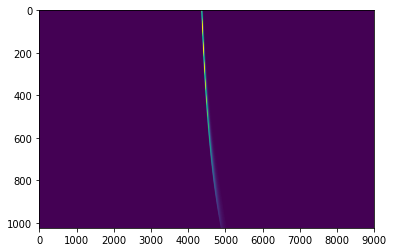

In [16]:
import matplotlib.pyplot as plt
plt.imshow(frbs[0], interpolation='nearest', aspect='auto')

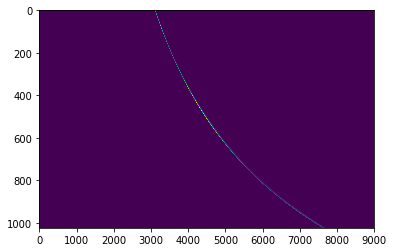

In [9]:
plt.imshow(frbs[1], interpolation='nearest', aspect='auto')

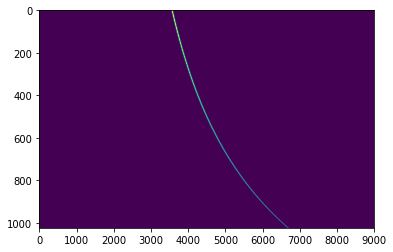

In [10]:
plt.imshow(frbs[2], interpolation='nearest', aspect='auto')

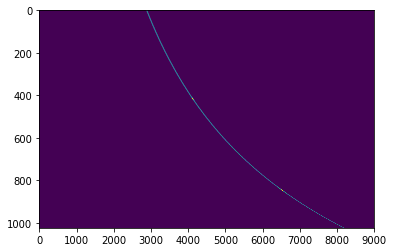

In [11]:
plt.imshow(frbs[3], interpolation='nearest', aspect='auto')

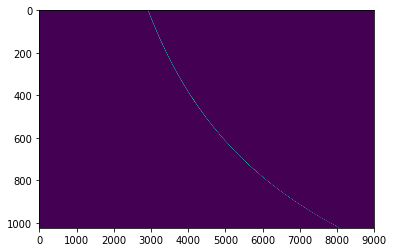

In [12]:
plt.imshow(frbs[4], interpolation='nearest', aspect='auto')

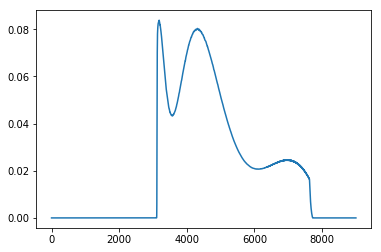

In [17]:
plt.plot(frbs[1].sum(axis=0))

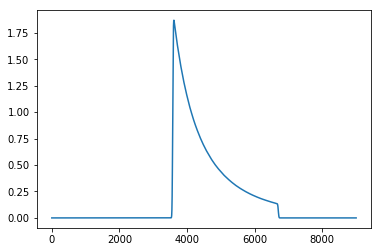

In [21]:
plt.plot(frbs[2].sum(axis=0))

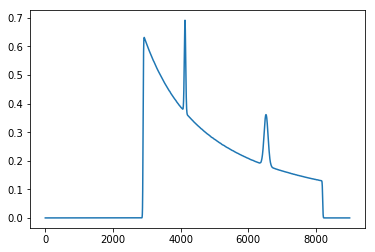

In [22]:
plt.plot(frbs[3].sum(axis=0))

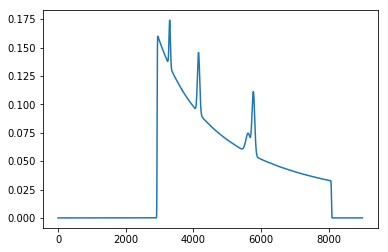

In [23]:
plt.plot(frbs[4].sum(axis=0))